In [1]:
# Get some code for generating test problems from PyAMG
# PyAMG: https://github.com/pyamg/pyamg
!wget -Nq https://raw.githubusercontent.com/pyamg/pyamg/master/pyamg/gallery/diffusion.py
!wget -Nq https://raw.githubusercontent.com/pyamg/pyamg/master/pyamg/gallery/stencil.py
import stencil
import diffusion
import scipy.sparse as sp
import scipy.sparse.linalg as la
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

# Non-linear diffusion-reaction problem
def A(u,gamma):
    N = len(u)
    n = int(np.sqrt(N))
    h = 1.0/(n+1)
    sten = diffusion.diffusion_stencil_2d(epsilon=1.0, theta=0.0, type='FD')
    diff = (1.0/(h*h))*stencil.stencil_grid(sten, (n,n), format='csr')
    return diff*u + gamma*np.multiply(u,np.exp(u))

def RHS(N,gamma):
    f = np.zeros(N)
    n = int(np.sqrt(N))
    h = 1.0/(n+1)
    for i in range(n):
        for j in range(n):
            x = (i+1)*h
            y = (j+1)*h
            f[i + j*n] = 2*((x - x*x) + (y-y*y)) + gamma*(x - x*x)*(y - y*y)*np.exp((x - x*x)*(y - y*y))
    return f

def Soln(N):
    f = np.zeros(N)
    n = int(np.sqrt(N))
    h = 1.0/(n+1)
    for i in range(n):
        for j in range(n):
            x = (i+1)*h
            y = (j+1)*h
            f[i + j*n] = (x - x*x)*(y-y*y)
    return f

# Define non-linear Gauss-Seidel
def NonLinearGaussSeidel(u,f,gamma):
    numNewtonSteps = 1
    N = len(u)
    n = int(np.sqrt(N))
    h = 1.0/(n+1)
    Au = A(u,gamma)
    for i in range(len(u)):
        for step in range(numNewtonSteps):
            u[i] = u[i] - (Au[i] - f[i])/(4.0/(h*h) + gamma*(1.0 - u[i])*np.exp(u[i]))
    return u

# Linear interpolation in 2D
def LinearInterpolation2D(n):
    N = (n-1)*(n-1) # fine-grid matrix size
    n_c = int(n/2) # coarse-grid number of points in 1D
    N_c = (n_c-1)*(n_c-1) # coarse-grid matrix size
    P = np.zeros((N,N_c))
    for row in range(N):
        x = row % (n-1)
        y = int(row / (n-1))
        # Four point interpolation
        if x % 2 == 0 and y % 2 == 0:
            x_c = int(x/2 - 1)
            y_c = int(y/2 - 1)
            if x_c >= 0 and y_c >= 0:
                P[row,x_c + (n_c-1)*y_c] = 0.25
            if (x_c+1) < n_c-1 and y_c >= 0:
                P[row,(x_c+1) + (n_c-1)*y_c] = 0.25
            if x_c >= 0 and (y_c+1) < n_c-1:
                P[row,x_c + (n_c-1)*(y_c+1)] = 0.25
            if (x_c+1) < n_c-1 and (y_c+1) < n_c-1:
                P[row,(x_c+1) + (n_c-1)*(y_c+1)] = 0.25
        # Two-point x interpolation
        elif x % 2 == 0:
            x_c = int(x/2 - 1)
            y_c = int(y/2)
            if x_c >= 0:
                P[row,x_c + (n_c-1)*y_c] = 0.5
            if (x_c+1) < n_c-1:
                P[row,(x_c+1) + (n_c-1)*y_c] = 0.5
        # Two-point y interpolation
        elif y % 2 == 0:
            x_c = int(x/2)
            y_c = int(y/2 - 1)
            if y_c >= 0:
                P[row,x_c + (n_c-1)*y_c] = 0.5
            if (y_c+1) < n_c-1:
                P[row,x_c + (n_c-1)*(y_c+1)] = 0.5
        # Injected C point
        else:
            x_c = int(x/2)
            y_c = int(y/2)
            P[row,x_c + (n_c-1)*y_c] = 1.0
    return P

# Restriction by full-weighting
def RestrictionFullWeighting2D(n):
    P = LinearInterpolation2D(n)
    R = 0.25*P.transpose()
    return R

In [2]:
# Recursive FAS V-cycle
def FAS(u,f,gamma):
    # Get the problem size
    N = len(u)
    n = int(np.sqrt(N)) + 1
    
    # Do non-linear relaxation
    u = NonLinearGaussSeidel(u,f,gamma)
    
    # If problem still large, go to the coarse grid
    if N > 1:
        # Get the restriction operator
        R = RestrictionFullWeighting2D(n)
    
        # Restrict the residual AND the solution
        r_c = np.dot(R,f - A(u,gamma))
        u_c = np.dot(R, u)
    
        # Define coarse right-hand side and call the recursion
        f_c = A(u_c,gamma) + r_c
        u_c_before = u_c.copy()
        tilde_u_c = FAS(u_c,f_c,gamma)
        
        # Get the coarse-grid correction, interpolate and add
        e_c = tilde_u_c - u_c_before
        P = LinearInterpolation2D(n)
        u = u + np.dot(P, e_c)
        
    # Do further non-linear relaxation
    u = NonLinearGaussSeidel(u,f,gamma)
    
    return u
        

3969
0.06993524324137008


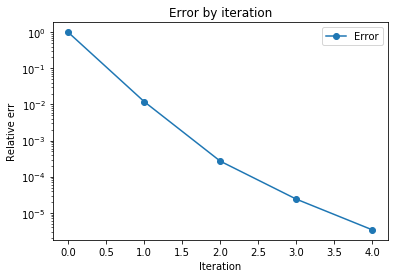

In [5]:
# Fine grid problem size
n = 64 # total points in 1D (0,n are the boundary points), choose a power of 2.
N = (n-1)*(n-1)

# Non-linearity strength
gamma = 1000

# RHS, soln, initial
u_final = Soln(N)
f = RHS(N,gamma)
u = np.zeros(N)
u_init = u.copy()

# Do FAS V-cycles
numIterations = 4
err = np.zeros(numIterations+1)
err[0] = np.linalg.norm(u_final - u)
for it in range(numIterations):
    u = FAS(u,f,gamma)
    err[it+1] = np.linalg.norm(u_final - u)

# Plot error by iteration
plt.figure()
plt.title('Error by iteration')
plt.xlabel('Iteration')
plt.ylabel('Relative err')
plt.semilogy(err/err[0],'-o')
plt.legend(['Error'])

# Print convergence factor
CF = np.prod(err[1:len(err)-1]/err[0:len(err)-2])**(1.0/numIterations)
print(N)
print(CF)